# ReadEasy

### Problem:

Randomized Controlled Trial are prospective studies that measure the effectiveness of a new intervention or treatment. The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

### Objective:
Researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.
### Solution:

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc)  to enable researchers to skim through the literature and dive deeper when necessary.


## Getting the data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
import os
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
# Preprocessing function
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.
      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev = validation
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [ ]:
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
# Turning our list of dictionaries into pandas DataFrame
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
train_df.shape

(180040, 4)

In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

Inference: Sentences with the `OBJECTIVE` label are the least common.

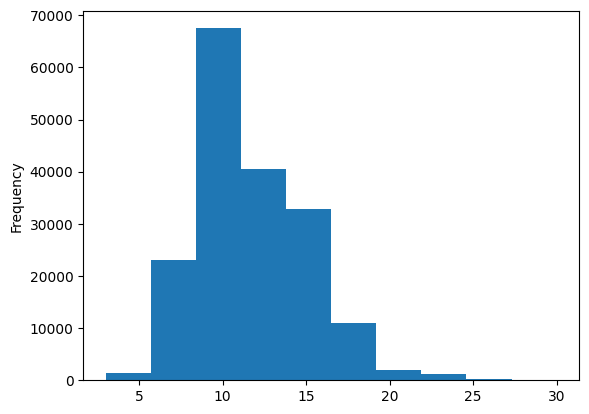

In [ ]:
train_df.total_lines.plot.hist();

Inference: Most of the abstracts are around 7 to 15 sentences in length.

In [ ]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# First 5 lines of training sentences
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Encoding

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling


## Model 0: TF-IDF Multinomial Naive Bayes

Using TFIDF with sklearn's Pipeline


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])


model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

Inference: 72.1% accuracy

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix

In [ ]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data for deep sequence models

*   The vectorization layer will convert our text to numbers.

*   The embedding layer will capture the relationships between those numbers.








In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

Distribution of sentence lengths

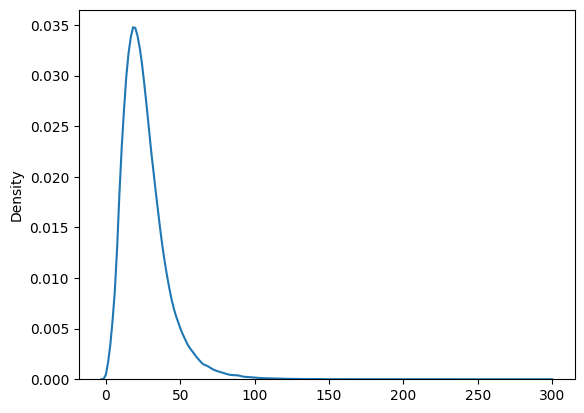

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(sent_lens);

Inference: The vast majority of sentences are between 0 and 50 tokens in length.

In [ ]:
# Maximum sentence length in the training set
max(sent_lens)

296

In [ ]:
# Using percentile to find the value which covers 95% of the sentence lengths
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

Inference: 95% of the sentences in our training set have a length of 55 tokens or less; we'll use that as our `output_sequence_length` parameter in text vectorization.

In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

max_tokens = 68000
text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary given in paper
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# # Test out text vectorizer
# import random
# target_sentence = random.choice(train_sentences)
# print(f"Text:\n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

In [ ]:
# Number of words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [ ]:
# Embedding layer will take the integer outputs of our `text_vectorization` layer as inputs
# and convert them to feature vectors of size `output_dim`.

# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")


Inference:
*   This array represents embedded sentences, it means you have 1 sentence with 55 words, and each word is embedded into a 128-dimensional vector.

*   The "128-dimensional vector" means that each word in your text is represented as a vector with 128 numerical values.
*   These values are real numbers and are designed in such a way that similar words in meaning will have similar vector representations, and the vector space encodes relationships between words.


*   Word embeddings are trained on large text corpora and learn to place words in a vector space based on their context and meaning. This means that words with similar meanings will be closer to each other in the vector space, and the vector arithmetic can capture relationships like "king - man + woman = queen."




In [ ]:
# Turning our data into TensorFlow Datasets as `tf.data` API provides methods which enable faster data loading
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

Deep models structure:

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```


In [ ]:
# Neural network model
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=10,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)) # only validate on 10% of batches
                              )

Epoch 1/10
562/562 [==============================] - 22s 32ms/step - loss: 0.9227 - accuracy: 0.6342 - val_loss: 0.6838 - val_accuracy: 0.7387
Epoch 2/10
562/562 [==============================] - 10s 18ms/step - loss: 0.6515 - accuracy: 0.7600 - val_loss: 0.6266 - val_accuracy: 0.7746
Epoch 3/10
562/562 [==============================] - 9s 15ms/step - loss: 0.6126 - accuracy: 0.7774 - val_loss: 0.5919 - val_accuracy: 0.7896
Epoch 4/10
562/562 [==============================] - 5s 9ms/step - loss: 0.5861 - accuracy: 0.7899 - val_loss: 0.5768 - val_accuracy: 0.7962
Epoch 5/10
562/562 [==============================] - 5s 9ms/step - loss: 0.5898 - accuracy: 0.7926 - val_loss: 0.5603 - val_accuracy: 0.7972
Epoch 6/10
562/562 [==============================] - 5s 8ms/step - loss: 0.5815 - accuracy: 0.7919 - val_loss: 0.5580 - val_accuracy: 0.8012
Epoch 7/10
562/562 [==============================] - 5s 9ms/step - loss: 0.5593 - accuracy: 0.7995 - val_loss: 0.5438 - val_accuracy: 0.8078
E

In [ ]:
# Evaluate on whole validation dataset (we only validated on 10% of batches during training)
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5272 - accuracy: 0.8112


[0.5272229909896851, 0.8112339377403259]

In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[5.6864190e-01, 1.2033377e-01, 8.2524948e-02, 1.8676810e-01,
        4.1731268e-02],
       [4.9242336e-01, 2.6360217e-01, 8.5467622e-03, 2.0659295e-01,
        2.8834775e-02],
       [1.3325045e-01, 3.5741562e-03, 8.7639590e-04, 8.6226046e-01,
        3.8557966e-05],
       ...,
       [9.6127487e-06, 2.3460179e-04, 2.3510023e-03, 9.5559135e-06,
        9.9739528e-01],
       [9.2796430e-02, 3.8957417e-01, 1.7459625e-01, 7.4480250e-02,
        2.6855290e-01],
       [3.9697494e-02, 9.3701732e-01, 1.7230790e-02, 2.2479857e-03,
        3.8064590e-03]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 81.12339467761154,
 'precision': 0.8071198787838713,
 'recall': 0.8112339467761155,
 'f1': 0.807893100903686}

## Model 2: Transfer Learning with pretrained token embeddings + positional embeddings

The model structure will look like:

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```



In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
# random_training_sentence = random.choice(train_sentences)
# print(f"Random training sentence:\n{random_training_sentence}\n")
# use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
# print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
# print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

In [ ]:
# Inspect training dataframe
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `"line_number"` and `"total_lines"` columns are features which can be passed to a neural network as a **positional embedding**.
> Positional embedding is where the sentence appears in an abstract.



Meaning, if we were to predict the labels of sequences in an abstract our model had never seen, we could count the number of lines and the track the position of each individual line and pass it to our model.



But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our `"line_number"` and `"total_lines"` features.

In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

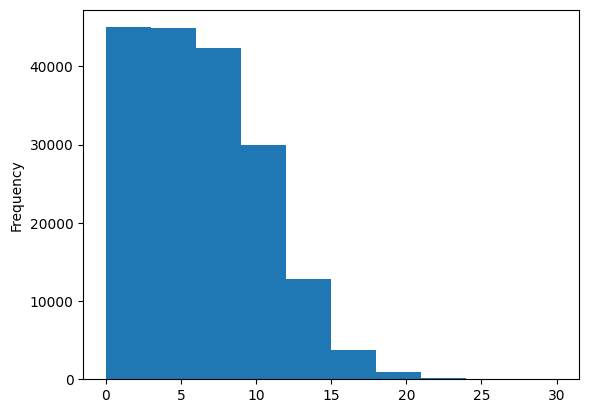

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

Inference: The majority of lines have a position of 15 or less.

Hence, let's set the depth parameter of `tf.one_hot` to 15.

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
# Check one-hot encoded "line_number" feature samples
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

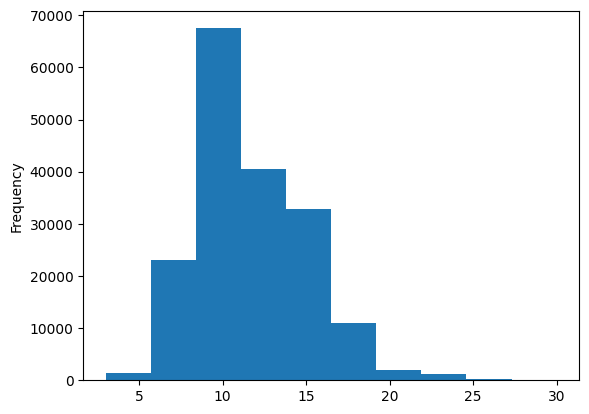

In [ ]:
# Check the distribution of total lines
train_df.total_lines.plot.hist();

Inference: A value of 20 looks like it covers the majority of samples.

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
# Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
z = layers.Dense(256, activation="relu")(token_outputs)
z = layers.Dropout(0.5)(z)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=z)
# Line numbers inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# Combine positional embeddings with combined token into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# Final model
model_2 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input
                                 ],
                         outputs=output_layer)

In [ ]:
# Get a summary of our token, char and positional embedding model
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]']        
  (KerasLayer)                                            24                                      
                                                                                                  
 dense_1 (Dense)             (None, 128)                  65664     ['universal_sentence_encoder[0
                                                                    ][0]']                        
                                                                                            

  Visualising the model

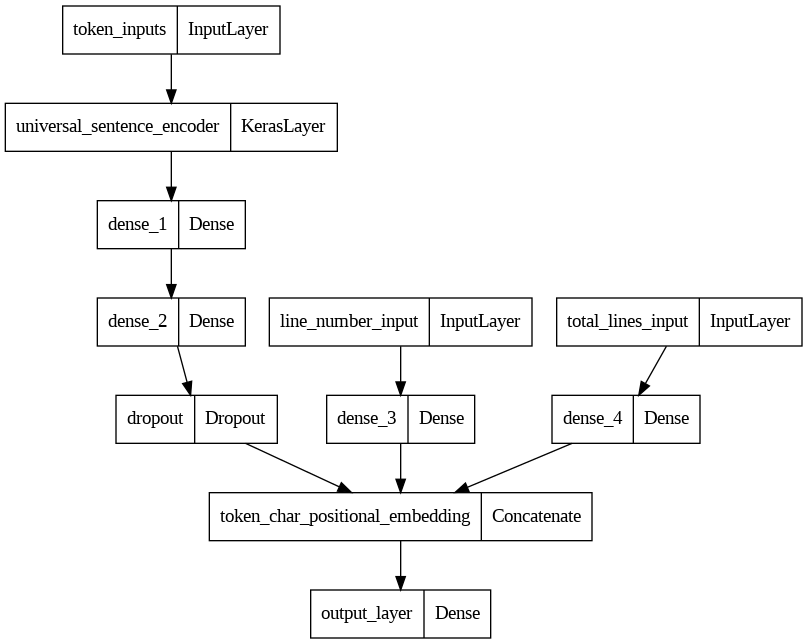

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_2)

Label smoothing helps to regularize our model (prevent overfitting) by making sure it doesn't get too focused on applying one particular label to a sample.




In [ ]:
# Compile token, char, positional embedding model
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create training dataset
train_pos_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens

                                                                ))
train_pos_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_token_dataset = tf.data.Dataset.zip((train_pos_token_data, train_pos_token_labels)) # combine data and labels
train_pos_token_dataset = train_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              ))
val_pos_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_token_dataset = tf.data.Dataset.zip((val_pos_token_data, val_pos_token_labels))
val_pos_token_dataset = val_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# test dataset
test_pos_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences
                                                               ))
test_pos_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_token_dataset = tf.data.Dataset.zip((test_pos_token_data, test_pos_token_labels))
test_pos_token_dataset = test_pos_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_token_dataset, val_pos_token_dataset, test_pos_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the token, char and positional embedding model
tf.config.run_functions_eagerly(True)
history_model_2 = model_2.fit(train_pos_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_token_dataset)),
                              epochs=10,
                              validation_data=val_pos_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_token_dataset)))

Epoch 1/10
562/562 [==============================] - 49s 73ms/step - loss: 1.1077 - accuracy: 0.7128 - val_loss: 0.9926 - val_accuracy: 0.7959
Epoch 2/10
562/562 [==============================] - 44s 78ms/step - loss: 0.9761 - accuracy: 0.8049 - val_loss: 0.9610 - val_accuracy: 0.8148
Epoch 3/10
562/562 [==============================] - 42s 74ms/step - loss: 0.9568 - accuracy: 0.8152 - val_loss: 0.9482 - val_accuracy: 0.8248
Epoch 4/10
562/562 [==============================] - 42s 76ms/step - loss: 0.9453 - accuracy: 0.8310 - val_loss: 0.9397 - val_accuracy: 0.8251
Epoch 5/10
562/562 [==============================] - 40s 72ms/step - loss: 0.9420 - accuracy: 0.8300 - val_loss: 0.9306 - val_accuracy: 0.8361
Epoch 6/10
562/562 [==============================] - 44s 78ms/step - loss: 0.9450 - accuracy: 0.8263 - val_loss: 0.9271 - val_accuracy: 0.8384
Epoch 7/10
562/562 [==============================] - 41s 73ms/step - loss: 0.9349 - accuracy: 0.8341 - val_loss: 0.9270 - val_accuracy:

In [ ]:
%%time
@tf.function
def predict_model_2(val_pos_token_dataset):
  return model_2.predict(val_pos_token_dataset, verbose=1)

model_2_pred_probs = predict_model_2(val_pos_token_dataset)
model_2_pred_probs

945/945 [==============================] - 16s 17ms/step
CPU times: user 18.4 s, sys: 1 s, total: 19.4 s
Wall time: 16.5 s


array([[0.5569951 , 0.10384001, 0.01418515, 0.3018137 , 0.02316609],
       [0.57182723, 0.1069466 , 0.06849734, 0.23276365, 0.01996515],
       [0.3241694 , 0.10324068, 0.13283624, 0.3659575 , 0.07379612],
       ...,
       [0.02579924, 0.08413132, 0.02284814, 0.03354413, 0.8336772 ],
       [0.01750777, 0.30416515, 0.06143555, 0.01983199, 0.5970595 ],
       [0.12027035, 0.7664427 , 0.051778  , 0.03585572, 0.02565324]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:

model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 84.34065934065934,
 'precision': 0.8433684924819651,
 'recall': 0.8434065934065934,
 'f1': 0.8404372846178012}

## Compare model results


In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pos_token_embed": model_2_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,81.123395,0.807120,0.811234,0.807893
pos_token_embed,84.340659,0.843368,0.843407,0.840437


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

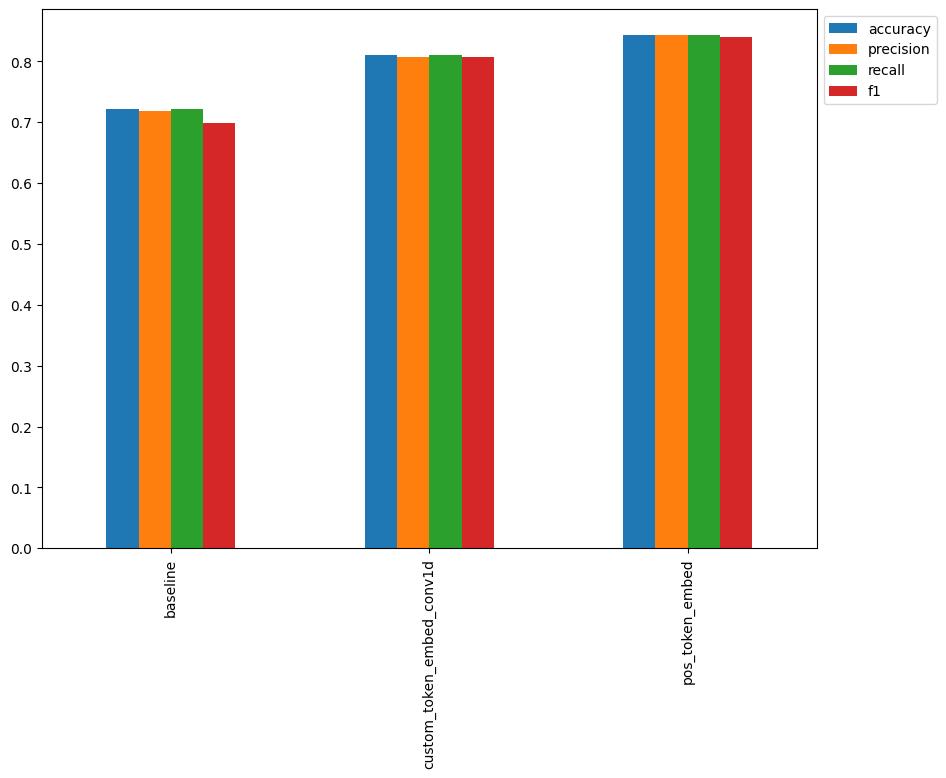

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

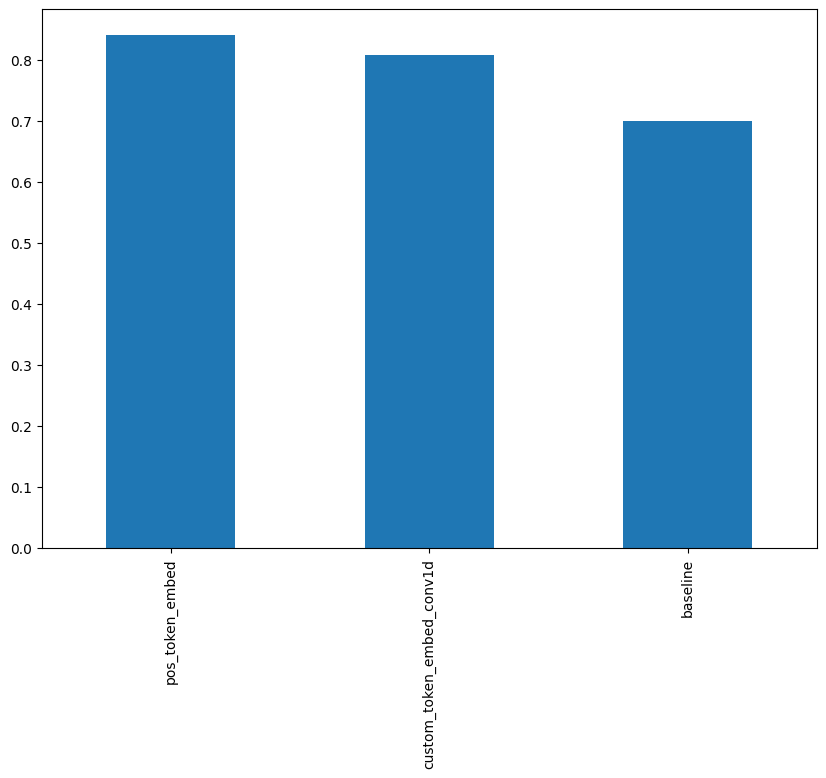

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Evaluating model on test dataset


In [ ]:
# Make predictions on the test dataset
test_pred_probs = model_2.predict(test_pos_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 16s 17ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 83.94225983076157,
 'precision': 0.8387335108039098,
 'recall': 0.8394225983076157,
 'f1': 0.836276242530704}

# Testing on a manual abstract

In [ ]:
test_abstract = "Alcoholic liver disease (ALD) and hepatitis C virus (HCV) infection represent, either alone or in combination, more than two thirds of all patients with liver disease in the Western world. This review discusses the epidemiology and combined impact of ALD and HCV on the progression of liver disease. ALD and HCV affect the progression of liver disease to liver cirrhosis and hepatocellular carcinoma (HCC) in a synergistic manner. Thus, the risk for HCC increases five times with a daily alcohol consumption of 80 g; in the presence of HCV it is increased 20-fold, and a combination of both risk factors leads to a more than 100-fold risk for HCC development. Alcohol consumption also decreases the response to interferon treatment which is probably due to a lack of compliance than a direct effect on HCV replication. Several molecular mechanisms are discussed that could explain the synergistic interaction of alcohol and HCV on disease progression. They include modulation of the immune response and apoptosis, increased oxidative stress via induction of CYP2E1 and the hepatic accumulation of iron. Thus, both HCV and alcohol independently cause hepatic iron accumulation in > 50% of patients probably due to suppression of the liver-secreted systemic iron hormone hepcidin. A better understanding of hepcidin regulation could help in developing novel therapeutic approaches to treat the chronic disease in the future. For now, it can be generally concluded that HCV-infected patients should abstain from alcohol and alcoholics should be encouraged to participate in detoxification programs."

In [ ]:
from spacy.lang.en import English

#The 'English' class is created when you call spacy.load and contains the shared vocabulary and language data, optional binary weights, e.g. provided by a trained pipeline
#The sentencizer in spaCy is a pipeline component that works by applying rules and heuristics to segment a text into individual sentences.
nlp = English()
sentencizer = nlp.add_pipe("sentencizer") # create sentence splitting pipeline object
doc = nlp(test_abstract)

In [ ]:
for sent in doc.sents:
  print(sent)

Alcoholic liver disease (ALD) and hepatitis C virus (HCV) infection represent, either alone or in combination, more than two thirds of all patients with liver disease in the Western world.
This review discusses the epidemiology and combined impact of ALD and HCV on the progression of liver disease.
ALD and HCV affect the progression of liver disease to liver cirrhosis and hepatocellular carcinoma (HCC) in a synergistic manner.
Thus, the risk for HCC increases five times with a daily alcohol consumption of 80 g; in the presence of HCV it is increased 20-fold, and a combination of both risk factors leads to a more than 100-fold risk for HCC development.
Alcohol consumption also decreases the response to interferon treatment which is probably due to a lack of compliance than a direct effect on HCV replication.
Several molecular mechanisms are discussed that could explain the synergistic interaction of alcohol and HCV on disease progression.
They include modulation of the immune response a

In [ ]:
abstract_lines = [str(sent) for sent in list(doc.sents)] # return detected sentences from doc in string type (not spaCy token type)
abstract_lines

['Alcoholic liver disease (ALD) and hepatitis C virus (HCV) infection represent, either alone or in combination, more than two thirds of all patients with liver disease in the Western world.',
 'This review discusses the epidemiology and combined impact of ALD and HCV on the progression of liver disease.',
 'ALD and HCV affect the progression of liver disease to liver cirrhosis and hepatocellular carcinoma (HCC) in a synergistic manner.',
 'Thus, the risk for HCC increases five times with a daily alcohol consumption of 80 g; in the presence of HCV it is increased 20-fold, and a combination of both risk factors leads to a more than 100-fold risk for HCC development.',
 'Alcohol consumption also decreases the response to interferon treatment which is probably due to a lack of compliance than a direct effect on HCV replication.',
 'Several molecular mechanisms are discussed that could explain the synergistic interaction of alcohol and HCV on disease progression.',
 'They include modulatio

In [ ]:
# Get total number of lines
total_lines_in_sample = len(abstract_lines)

# Go through each line in abstract and create a list of dictionaries containing features for each line
sample_lines = []
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict["text"] = str(line)
  sample_dict["line_number"] = i
  sample_dict["total_lines"] = total_lines_in_sample - 1
  sample_lines.append(sample_dict)
sample_lines

[{'text': 'Alcoholic liver disease (ALD) and hepatitis C virus (HCV) infection represent, either alone or in combination, more than two thirds of all patients with liver disease in the Western world.',
  'line_number': 0,
  'total_lines': 9},
 {'text': 'This review discusses the epidemiology and combined impact of ALD and HCV on the progression of liver disease.',
  'line_number': 1,
  'total_lines': 9},
 {'text': 'ALD and HCV affect the progression of liver disease to liver cirrhosis and hepatocellular carcinoma (HCC) in a synergistic manner.',
  'line_number': 2,
  'total_lines': 9},
 {'text': 'Thus, the risk for HCC increases five times with a daily alcohol consumption of 80 g; in the presence of HCV it is increased 20-fold, and a combination of both risk factors leads to a more than 100-fold risk for HCC development.',
  'line_number': 3,
  'total_lines': 9},
 {'text': 'Alcohol consumption also decreases the response to interferon treatment which is probably due to a lack of compli

In [ ]:
# Get all line_number values from sample abstract
test_abstract_line_numbers = [line["line_number"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_line_numbers_one_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_one_hot

<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
     

In [ ]:
# Make predictions on sample abstract features
test_abstract_pred_probs = model_2.predict(x=(test_abstract_line_numbers_one_hot,
                                                   test_abstract_total_lines_one_hot,
                                                   tf.constant(abstract_lines)
                                                   ))
test_abstract_pred_probs

1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[0.42285708, 0.05605445, 0.11386479, 0.26462603, 0.14259769],
       [0.44110072, 0.05467087, 0.1511379 , 0.3168949 , 0.03619556],
       [0.3107394 , 0.17319413, 0.2753683 , 0.17278075, 0.06791741],
       [0.32887438, 0.18315826, 0.10231433, 0.14802401, 0.237629  ],
       [0.2157457 , 0.27164114, 0.12206699, 0.09507716, 0.29546902],
       [0.14635281, 0.29752132, 0.13482538, 0.09969338, 0.32160708],
       [0.07923363, 0.27830935, 0.16896336, 0.06128036, 0.41221336],
       [0.05145623, 0.27662456, 0.0690659 , 0.04690979, 0.55594355],
       [0.05815152, 0.7796088 , 0.02193115, 0.05851074, 0.08179779],
       [0.03899333, 0.7793312 , 0.03678222, 0.03176581, 0.11312754]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)
test_abstract_preds

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 0, 4, 4, 4, 4, 1, 1])>

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [label_encoder.classes_[i] for i in test_abstract_preds]
test_abstract_pred_classes

['BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS']

In [ ]:
# Visualize abstract lines and predicted sequence labels
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

BACKGROUND: Alcoholic liver disease (ALD) and hepatitis C virus (HCV) infection represent, either alone or in combination, more than two thirds of all patients with liver disease in the Western world.
BACKGROUND: This review discusses the epidemiology and combined impact of ALD and HCV on the progression of liver disease.
BACKGROUND: ALD and HCV affect the progression of liver disease to liver cirrhosis and hepatocellular carcinoma (HCC) in a synergistic manner.
BACKGROUND: Thus, the risk for HCC increases five times with a daily alcohol consumption of 80 g; in the presence of HCV it is increased 20-fold, and a combination of both risk factors leads to a more than 100-fold risk for HCC development.
RESULTS: Alcohol consumption also decreases the response to interferon treatment which is probably due to a lack of compliance than a direct effect on HCV replication.
RESULTS: Several molecular mechanisms are discussed that could explain the synergistic interaction of alcohol and HCV on dis